In [1]:
%matplotlib notebook
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation

import traceback, functools, pprint, math, random

import pymunk
import pymunk.matplotlib_util
from pymunk.vec2d import Vec2d
from IPython.display import HTML

def print_errors_to_stdout(fun):
    @functools.wraps(fun)
    def wrapper(*args,**kw):
        try:
            return fun(*args,**kw)
        except Exception:
            traceback.print_exc()
            raise
    return wrapper

<IPython.core.display.Javascript object>


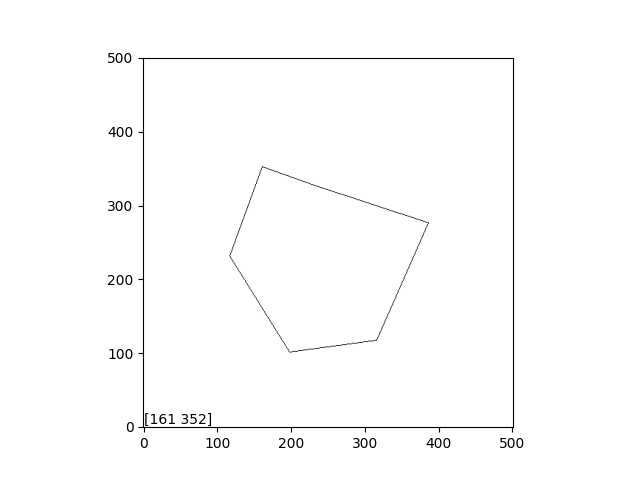

In [2]:
nx, ny = 501, 501

plt.figure()
img = np.full((nx, ny, 3), 255, dtype='uint8')

plt.ion()

im = plt.imshow(img, origin='lower')
fig = plt.gcf()
ax = plt.gca()

text=ax.text(0,0, "", va="bottom", ha="left")

points = np.array([], dtype='uint8').reshape((-1, 2))
snap_threshold = 10

@print_errors_to_stdout
def on_press(event):
    global points
    
    if plt.isinteractive():
        # debug printout
        # tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
        # text.set_text(tx)

        x_coord, y_coord = int(event.xdata), int(event.ydata)
        point = np.array([x_coord, y_coord])
        
        if len(points) > 1 and all(np.abs(point - points[0]) < snap_threshold):
            point = points[0]
            plt.ioff()
        
        points = np.vstack((points, point))
        text.set_text(f'{point}')

        if len(points) > 1:
            n = len(points)
            cv2.line(img, tuple(points[n-2]), tuple(points[n-1]), (0, 0, 0), thickness=1)

        im.set_data(img)

        plt.draw()

@print_errors_to_stdout
def on_move(event):
    if plt.isinteractive() and event.inaxes is not None:
        tmp_img = np.copy(img)
        
        x_coord, y_coord = int(event.xdata), int(event.ydata)
        point = np.array([x_coord, y_coord])
        
        if len(points) >= 1:
            n = len(points)
            
            if all(np.abs(point - points[0]) < snap_threshold):
                point = points[0]
                
            cv2.line(tmp_img, tuple(points[n-1]), tuple(point), (0, 0, 0), thickness=1)
            
        im.set_data(tmp_img)

        plt.draw()
        
cid = fig.canvas.mpl_connect('button_press_event', on_press)
cid = fig.canvas.mpl_connect('motion_notify_event', on_move)

In [3]:
def centroid(points):
    """Returns the centroid of a polygon"""
    n = len(points)
    def next(i):
        return (i + 1) % n
    shoelace = [points[i, 0]*points[next(i), 1] - points[next(i), 0]*points[i, 1] for i in range(n)]
    list_x = [(points[i, 0] + points[next(i), 0])*shoelace[i] for i in range(n)]
    list_y = [(points[i, 1] + points[next(i), 1])*shoelace[i] for i in range(n)]
    
    const = 1/(6*polygon_signed_area(points))
    C_x = const * sum(list_x)
    C_y = const * sum(list_y)
    
    return C_x, C_y
    
def polygon_signed_area(points):
    """Returns the signed area of a polygon as described by the shoelace formula"""
    n = len(points)
    def next(i):
        return (i + 1) % n
    
    res = sum([points[i, 0]*points[next(i), 1] - points[next(i), 0]*points[i, 1] for i in range(n)])
    return res/2

def scale_polygon(points):
    """Scales the polygon so that the largest dimension is approximately 100 units"""
    width = max(points[:, 0]) - min(points[:, 0])
    height = max(points[:, 1]) - min(points[:, 1])
    
    larger = max(width, height)
    scale = 100/larger
    
    return np.around(points * scale).astype(np.int32)

def scale_and_center_polygon(points):
    points = scale_polygon(points)

    C_x, C_y = centroid(points)

    points[:, 0] -= round(C_x)
    points[:, 1] -= round(C_y)
    
    return points

In [4]:
points = scale_and_center_polygon(points[:-1])
# points = scale_and_center_polygon(points)
points

array([[-30,  48],
       [-47,   3],
       [-16, -45],
       [ 27, -40],
       [ 53,  20],
       [ -3,  38]], dtype=int32)

<IPython.core.display.Javascript object>


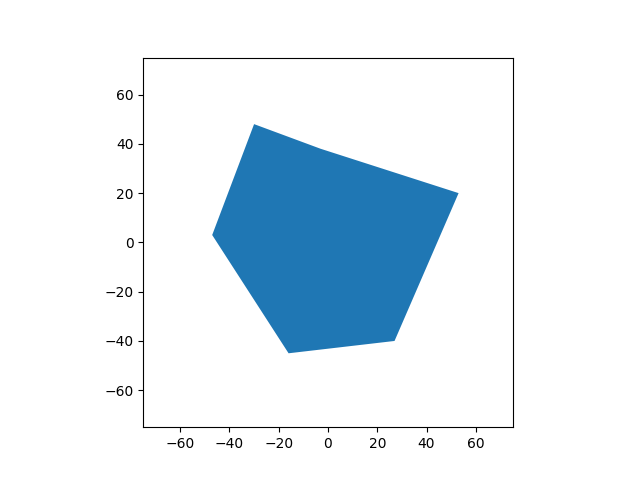

In [5]:
plt.figure()
plt.fill(points[:, 0], points[:, 1])
plt.gca().set_aspect("equal")
plt.xlim((-75, 75))
plt.ylim((-75, 75))
plt.show()

In [6]:
def signed_area(p1, p2, p3):
    """
    Returns the twice the signed area of a triangle defined by the points (p1, p2, p3).
    The sign is positive if and only if (p1, p2, p3) form a counterclockwise cycle
    (a left turn). If the points are colinear, then this returns 0. If the points form
    a clockwise cycle, this returns a negative value.
    
    This method is described in further detail in Preparata and Shamos (1985). 
    """
    mat = np.hstack((np.vstack((p1, p2, p3)), np.ones((3, 1)))).astype('int32')
    return round(np.linalg.det(mat)) # since matrix only has integers, determinant should itself be an integer

def convex_hull(points):
    """
    Returns the convex hull of a set of points, which defines a convex polygon. 
    The returned points form a counterclockwise sequence.
    
    This is an implementation of Jarvis's march algorithm, which runs in O(nh) time.
    """
    assert len(points) >= 3
    
    l_idx = np.argmin(points, axis=0)[0]
    l = points[l_idx]
    
    result = [l]
    start = 0
    
    p, q = l_idx, None
    while True:
        q = (p + 1) % len(points)
        
        for i in range(len(points)):
            if i == p:
                continue
            v1, v2 = points[i]-points[p], points[q]-points[i]
            d = signed_area(points[p], points[i], points[q])
            if d > 0 or (d == 0 and np.linalg.norm(v1) > np.linalg.norm(v2)):
                q = i
                
        p = q
        if p == l_idx:
            break
        result.append(points[q])
        
    return np.array(result)

# ch = convex_hull(points[:-1])
ch = convex_hull(points)

<IPython.core.display.Javascript object>


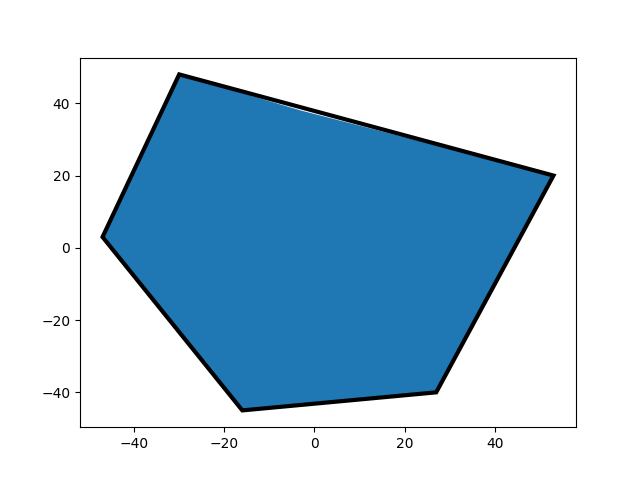

In [7]:
plt.figure()
plt.fill(points[:, 0], points[:, 1])
plt.fill(ch[:, 0], ch[:, 1], facecolor='none', edgecolor='black', linewidth=3)
plt.show()

In [8]:
def antipodal_pairs(points):
    """
    Returns the antipodal pairs and piecewise function of a convex polygon. The points must be in
    a counterclockwise sequence. This algorithm is adapted from pseudocode in Preparata and Shamos (1985)
    and was modified to also return a piecewise diameter function as described in Goldberg (1993).
    
    The format of the returned antipodal pairs is a list of (p, q) pairs, where p and q are indices that 
    correspond directly to indices of the points array that was passed to this function.
    
    The format of the piecewise function is a list of (m, l, i) tuples, where l and i describe a section
    of the piecewise diameter function in the form l*cos(theta-i). In the paper, the diameter is described
    as a series of l*sin(theta-i) functions, but here pi/2 is added to i, so they are functionally equivalent.
    m describes the maximum theta for which l*cos(theta-i) is valid, and the minimum angle is the m in the
    previous tuple in the list.
    
    This procedure is described in further detail in Preparata and Shamos (1985).
    """
    res = []
    piecewise_diameter = []
    n = len(points)
    def _next(i):
        return (i + 1) % n
    def previous(i):
        return (i - 1) % n
    
    p = n - 1
    q = _next(p)
    while signed_area(points[p], points[_next(p)], points[_next(q)]) > \
          signed_area(points[p], points[_next(p)], points[q]):
        q = _next(q)
        
    p0, q0 = 0, q

    while q != p0:
        p = _next(p)
        res.append([p, q])
        while signed_area(points[p], points[_next(p)], points[_next(q)]) > \
              signed_area(points[p], points[_next(p)], points[q]):
            q = _next(q)
            
            # add to piecewise diameter function
            
            p1, p2 = points[p], points[previous(q)]
            max_angle = get_angle(points[q], points[previous(q)])
            chord_length = np.linalg.norm(p2-p1)
            angle_max_length = get_angle(p1, p2) + np.pi/2
            
            piecewise_diameter.append((max_angle, chord_length, angle_max_length))
            print(p1, p2, max_angle, angle_max_length)
            
            if (p, q) != (q0, p0): # and sorted([p, q]) not in res:
                res.append([p, q])                
            else:
                break
        if signed_area(points[p], points[_next(p)], points[_next(q)]) == \
           signed_area(points[p], points[_next(p)], points[q]):
            # parallel edges TODO
            if (p, q) != (q0, n-1): # and sorted([p, q]) not in res:
                res.append([p,_next(q)])
            else:
                break
                
        if q != p0:
            p1, p2 = points[p], points[q]
            max_angle = get_angle(points[p], points[_next(p)])
            chord_length = np.linalg.norm(p2-p1)
            angle_max_length = get_angle(p1, p2) + np.pi/2
            
            piecewise_diameter.append((max_angle, chord_length, angle_max_length))
            print(p1, p2, max_angle, angle_max_length)
                
    return np.array(res), piecewise_diameter

def get_angle(p1, p2):
    """Returns the angle of the vector from p1 to p2"""
    v = p2 - p1
    return np.arctan2(*v[::-1]) # % np.pi

[-47   3] [53 20] -0.9973558006400677 1.7391864839424265
[-16 -45] [53 20] -0.32536064701664213 2.3263526055252353
[-16 -45] [-30  48] 0.11575921772081071 3.2910083635062612
[ 27 -40] [-30  48] 1.1618884978439712 3.7163685152887735
[53 20] [-30  48] 1.209592571301215 4.387028333368048


<IPython.core.display.Javascript object>


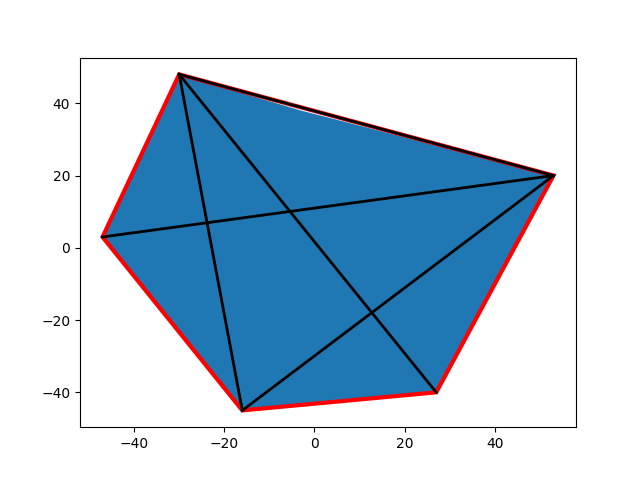

In [9]:
plt.figure()
plt.fill(points[:, 0], points[:, 1])
plt.fill(ch[:, 0], ch[:, 1], facecolor='none', edgecolor='red', linewidth=3)
for p1, p2 in antipodal_pairs(ch)[0]:
    x1, y1 = ch[p1]
    x2, y2 = ch[p2]
    plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
plt.show()

[-47   3] [53 20] -0.9973558006400677 1.7391864839424265
[-16 -45] [53 20] -0.32536064701664213 2.3263526055252353
[-16 -45] [-30  48] 0.11575921772081071 3.2910083635062612
[ 27 -40] [-30  48] 1.1618884978439712 3.7163685152887735
[53 20] [-30  48] 1.209592571301215 4.387028333368048


<IPython.core.display.Javascript object>


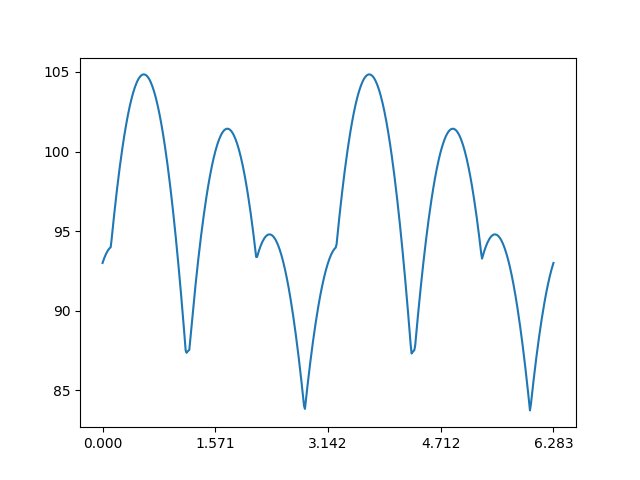

In [10]:
piecewise_diameter = antipodal_pairs(ch)[1]

def generate_range(piecewise_func, period, domain=(0, 2*np.pi)):
    while piecewise_func[0][0] >= domain[0]:
        shift = [(p[0] - period,) + p[1:] for p in piecewise_func]
        piecewise_func = shift + piecewise_func
        
    while piecewise_func[len(piecewise_func) - 1][0] <= domain[1]:
        shift = [(p[0] + period,) + p[1:] for p in piecewise_func]
        piecewise_func = piecewise_func + shift
    
    return piecewise_func

def generate_func(piecewise_func):
    """Convenience function to generate a callable piecewise function based off piecewise_func"""
    
    def func(theta):
        for i in range(1, len(piecewise_func)):
            if piecewise_func[i-1][0] <= theta < piecewise_func[i][0]:
                return piecewise_func[i][1] * abs(math.cos(theta-piecewise_func[i][2]))
            
    return func
diameter_func = generate_func(generate_range(piecewise_diameter, np.pi))

x = np.linspace(0, 2*np.pi, 500)
y = np.array([diameter_func(t) for t in x])

plt.figure()
plt.plot(x, y)
plt.xticks(np.linspace(0, 2*np.pi, 5))
plt.show()

In [11]:
generate_range(piecewise_diameter, np.pi)

[(-0.9973558006400677, 101.43470806385751, 1.7391864839424265),
 (-0.32536064701664213, 94.79451460923254, 2.3263526055252353),
 (0.11575921772081071, 94.04786015641186, 3.2910083635062612),
 (1.1618884978439712, 104.84750831564858, 3.7163685152887735),
 (1.209592571301215, 87.5956619930462, 4.387028333368048),
 (2.1442368529497253, 101.43470806385751, 1.7391864839424265),
 (2.816232006573151, 94.79451460923254, 2.3263526055252353),
 (3.257351871310604, 94.04786015641186, 3.2910083635062612),
 (4.303481151433765, 104.84750831564858, 3.7163685152887735),
 (4.351185224891008, 87.5956619930462, 4.387028333368048),
 (2.1442368529497253, 101.43470806385751, 1.7391864839424265),
 (2.816232006573151, 94.79451460923254, 2.3263526055252353),
 (3.257351871310604, 94.04786015641186, 3.2910083635062612),
 (4.303481151433765, 104.84750831564858, 3.7163685152887735),
 (4.351185224891008, 87.5956619930462, 4.387028333368048),
 (5.285829506539518, 101.43470806385751, 1.7391864839424265),
 (5.957824660